In [1]:
from hamcrest import none
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tcn import TCN, tcn_full_summary
import predict
batch_size, time_steps, input_dim = none, 5, 9
dataset=pd.read_csv('SolarPrediction_aligned_Sun.csv',engine='python',nrows=576*15)
dataset=dataset.drop("Data",axis=1)
dataset=dataset.drop("Time",axis=1)
dataset.head(5)


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,8,2.58,51,30.43,103,77.27,11.25,22020,67080
1,310,2.83,51,30.43,103,153.44,9.00,22020,67080
2,1206,2.16,51,30.43,103,142.04,7.87,22020,67080
3,1505,2.21,51,30.43,103,144.12,18.00,22020,67080
4,1809,2.25,51,30.43,103,67.42,11.25,22020,67080


In [2]:
dataset=dataset.values

取出來的數字不知道為甚麼做%會一直變 ==
把值用一變數取出改為int再寫入
重複執行會重複扣==

In [3]:

# take=np.zeros(len(dataset))
# take=dataset[:,0]


In [4]:
# take[:]=take[:]-1472724000
# take

In [5]:
# for i in range(0,len(dataset)):
#     take[i]=take[i]%(60*60*24)

# print(dataset[0,0])

把take寫回去

In [6]:
# dataset[:,0]=take
# print(dataset)

之前用作存時間整理的

In [7]:
# store=pd.DataFrame(dataset,columns=["UNIXTime","Data","Time","Radiation","Temperature","Pressure","Humidity","WindDirection(Degrees)","Speed","TimeSunRise","TimeSunSet"])
# store.to_csv("SolarPrediction_time_aligned.csv",index=False)

在這邊scalar會被設定為對七筆資料做scalar
導致最後輸出結果無法scalar回去
到後面分資料實在scalar
存有對輸出scalar的資料

In [8]:
dataset[:,1]

array([  2.58,   2.83,   2.16, ..., 344.9 , 365.66, 355.57])

In [9]:

dataset=dataset.astype('float32')

scalar1=MinMaxScaler(feature_range=(0,1))
scalar2=MinMaxScaler(feature_range=(0,1))
scalar_dim=dataset[:,1]
dataset=scalar1.fit_transform(dataset)

scalar_dim=scalar_dim.reshape(len(dataset),1)
print(scalar_dim)
scalar_dim=scalar2.fit_transform(scalar_dim)
print(scalar_dim)


[[  2.58]
 [  2.83]
 [  2.16]
 ...
 [344.9 ]
 [365.66]
 [355.57]]
[[0.00089369]
 [0.00104993]
 [0.00063121]
 ...
 [0.21482898]
 [0.2278031 ]
 [0.22149728]]


In [10]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)- train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

print(train.shape)
print(train)
print(test.shape)
#print(test)

(5788, 9)
[[5.8056499e-05 8.9368853e-04 3.3333325e-01 ... 5.5555558e-01
  0.0000000e+00 1.0000000e+00]
 [3.5646691e-03 1.0499278e-03 3.3333325e-01 ... 4.4444445e-01
  0.0000000e+00 1.0000000e+00]
 [1.3968393e-02 6.3120667e-04 3.3333325e-01 ... 3.8864198e-01
  0.0000000e+00 1.0000000e+00]
 ...
 [1.7786188e-01 4.3747015e-05 2.6666665e-01 ... 2.2222222e-01
  7.1428680e-01 2.9999924e-01]
 [1.8134527e-01 5.6246121e-05 2.6666665e-01 ... 2.7753085e-01
  7.1428680e-01 2.9999924e-01]
 [1.8480544e-01 6.2495703e-05 2.6666665e-01 ... 2.2222222e-01
  7.1428680e-01 2.9999924e-01]]
(2852, 9)


以下列的函式去執行
可以將每一筆資料對應前五個時間點及七筆資料
又有幾百筆資料做對應
故會有三為資料
注 在這邊分成target及分析內容

In [11]:
def create_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        #a=dataset第0行i~i+look_back個
        a=dataset[i:(i+look_back),0:9]
        dataX.append(a)
        dataY.append(dataset[i+look_back,1])
    return np.array(dataX),np.array(dataY)

    

In [12]:
#根據前面幾個資料來看下一步 彙整成look_back行的資料
#X用以輸入 Y用用以predict
look_back=5
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)
print(testX.shape)
#print(testX)
print(testY.shape)
print(trainX.shape)
print(trainY.shape)


(2846, 5, 9)
(2846,)
(5782, 5, 9)
(5782,)


TCN test

In [13]:
#tcn_layer = TCN(nb_filters=64,kernel_size=3,dropout_rate=0.0,padding='causal',activation='relu',input_shape=(time_steps, input_dim))
#tcn_layer = TCN(nb_filters=97,kernel_size=8,input_shape=(time_steps, input_dim))
tcn_layer = TCN(nb_filters=128,
                kernel_size=10,
                dropout_rate= 0.1,
                activation='relu',padding='causal',
                nb_stacks=1,
                dilations=(1, 2, 4, 8, 16, 32),
                input_shape=(time_steps, input_dim))
print('Receptive field size =', tcn_layer.receptive_field)

model = Sequential([tcn_layer,Dense(64),Dense(1)])
model.compile(optimizer='adam', loss='mse')
tcn_full_summary(model, expand_residual_blocks=False)


Receptive field size = 1135


Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.


In [14]:
model.fit(trainX, trainY, epochs=30,verbose=2)

Epoch 1/30
181/181 - 19s - loss: 0.1164 - 19s/epoch - 105ms/step
Epoch 2/30
181/181 - 14s - loss: 0.0056 - 14s/epoch - 77ms/step
Epoch 3/30
181/181 - 13s - loss: 0.0050 - 13s/epoch - 74ms/step
Epoch 4/30
181/181 - 13s - loss: 0.0046 - 13s/epoch - 73ms/step
Epoch 5/30
181/181 - 13s - loss: 0.0044 - 13s/epoch - 73ms/step
Epoch 6/30
181/181 - 13s - loss: 0.0042 - 13s/epoch - 74ms/step
Epoch 7/30
181/181 - 14s - loss: 0.0040 - 14s/epoch - 75ms/step
Epoch 8/30
181/181 - 13s - loss: 0.0039 - 13s/epoch - 74ms/step
Epoch 9/30
181/181 - 14s - loss: 0.0039 - 14s/epoch - 76ms/step
Epoch 10/30
181/181 - 15s - loss: 0.0038 - 15s/epoch - 81ms/step
Epoch 11/30
181/181 - 14s - loss: 0.0038 - 14s/epoch - 78ms/step
Epoch 12/30
181/181 - 15s - loss: 0.0038 - 15s/epoch - 85ms/step
Epoch 13/30
181/181 - 15s - loss: 0.0036 - 15s/epoch - 82ms/step
Epoch 14/30
181/181 - 14s - loss: 0.0037 - 14s/epoch - 79ms/step
Epoch 15/30
181/181 - 14s - loss: 0.0036 - 14s/epoch - 79ms/step
Epoch 16/30
181/181 - 15s - loss:

In [15]:
#轉為三維 再不是三圍的情況下
# trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
# testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1))

In [16]:
trainPre=model.predict(trainX)
testPre=model.predict(testX)
trainPre.shape
testPre.shape

89/89 [==============================] - 3s 29ms/step


(2846, 1)

In [17]:
trainPre=scalar2.inverse_transform(trainPre)
trainY=scalar2.inverse_transform([trainY])
testPre=scalar2.inverse_transform(testPre)
testY=scalar2.inverse_transform([testY])
print(trainPre.shape)
print(trainY.shape)
print(testPre.shape)
print(testY.shape)

(5782, 1)
(1, 5782)
(2846, 1)
(1, 2846)


In [18]:
print(trainY.shape)
print(trainPre.shape)
print(trainY[0,1])
print(trainPre[1,0])


(1, 5782)
(5782, 1)
2.0699998509781423
51.723476


In [19]:
#MSE是均方根誤差 即平均誤差 會被平均除下去 所以數據多不代表誤差會增加
trainScore=math.sqrt(mean_squared_error(trainY[0,:],trainPre[:,0]))
print('Train Score:%.2f RMSE'%(trainScore))
testScore=math.sqrt(mean_squared_error(testY[0,:],testPre[:,0]))
print('Test Score:%.2f RMSE'%(testScore))
MAE=mean_absolute_error(testY[0,:],testPre[:,0])
print('Test Score:%.2f MAE'%(MAE))

Train Score:91.40 RMSE
Test Score:110.69 RMSE
Test Score:60.00 MAE


In [20]:
print(trainY[0,:])
print(trainPre[:,0].shape)

[2.15000019 2.06999985 2.05999993 ... 1.23999998 1.22000004 1.23999998]
(5782,)


In [21]:
trainPredictplot=np.empty_like(scalar_dim)
#print(trainPredictplot)
trainPredictplot[:,:]=np.nan
#print(trainPredictplot)
trainPredictplot[look_back:len(trainPre)+look_back,:]=trainPre
print(trainPredictplot)
print(trainPredictplot.shape)

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
(8640, 1)


In [22]:
testPredictPlot=np.empty_like(scalar_dim)
testPredictPlot[:,:]=np.NaN
testPredictPlot[len(trainPre)+(look_back*2)+1:len(dataset)-1,:]=testPre
print(testPredictPlot)

[[      nan]
 [      nan]
 [      nan]
 ...
 [120.84619]
 [277.45053]
 [      nan]]


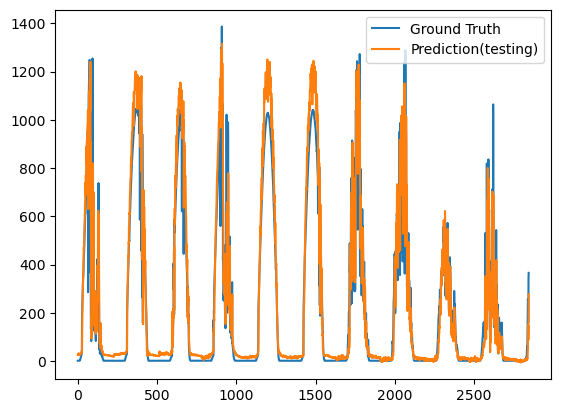

In [23]:
ground_truth=scalar2.inverse_transform(scalar_dim)
plt.plot(testY[0,:],label='Ground Truth')
plt.plot(testPre,label='Prediction(testing)')
plt.legend()
plt.show()

MAE: 60.0
RMSE: 110.69
R2 Score: 0.89
MAE: 60.0
RMSE: 110.69
R2 Score: 0.89
MAE: 60.0
RMSE: 110.69
R2 Score: 0.89


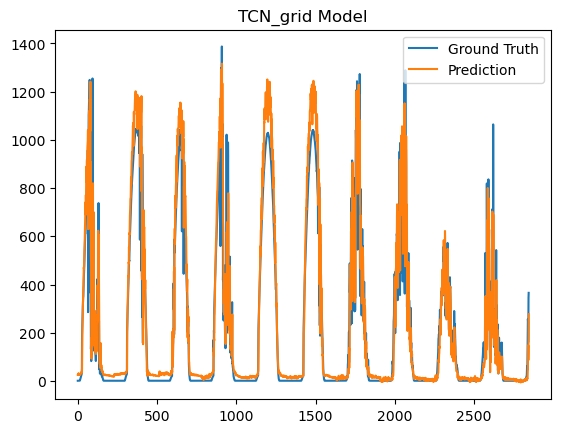

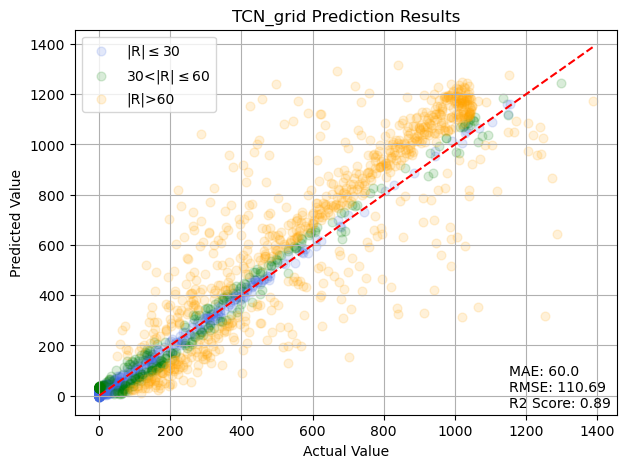

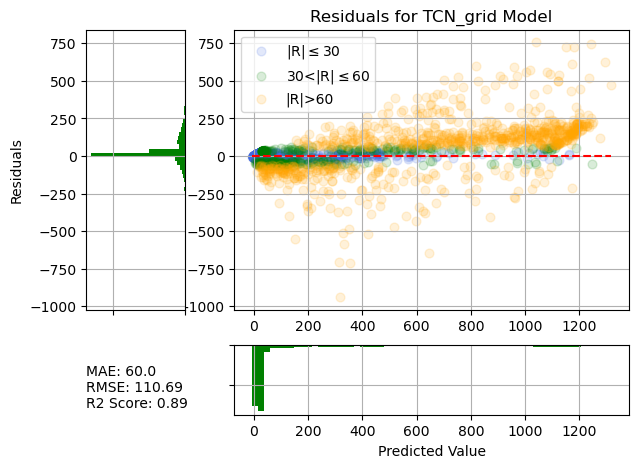

In [24]:
predict.my_self(testY[0,:],testPre[:,0],'TCN_grid')
predict.score_calculation(testY[0,:],testPre[:,0])
predict.plot_pred(testY[0,:],testPre[:,0],'TCN_grid')
predict.plot_residuals(testY[0,:],testPre[:,0],'TCN_grid')

In [25]:
# predict.my_self(testY[0,:],testPre[:,0],'TCN')
# predict.score_calculation(testY[0,:],testPre[:,0])
# predict.plot_pred(testY[0,:],testPre[:,0],'TCN')
# predict.plot_residuals(testY[0,:],testPre[:,0],'TCN')

In [26]:
error=testY[0,:]-testPre[:,0]
error=abs(error)
print(error)
error=sorted(error)
print(error[int(len(error)/3)])
print(error[int(len(error)*2/3)])

[ 24.69904064  26.02031496  26.33259371 ... 134.9228778  224.05381549
  88.20948438]
15.111504114721088
37.75269474090692
